In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


In [3]:
import pandas as pd

# Charger le fichier CSV
csv_path = '/kaggle/input/state-farm-distracted-driver-detection/driver_imgs_list.csv'
df = pd.read_csv(csv_path)

# Afficher les premières lignes du CSV
print(df.head())


  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg


In [4]:
import os
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm

# Charger le fichier CSV
csv_path = '/kaggle/input/state-farm-distracted-driver-detection/driver_imgs_list.csv'
df = pd.read_csv(csv_path)

# Afficher les premières lignes pour inspecter le contenu
print(df.head())

# Chemin d'accès aux images
main_path = '/kaggle/input/state-farm-distracted-driver-detection/imgs/train'

# Liste pour stocker les images et les labels
images = []
class_labels = []

# Taille d'entrée pour les images
input_size = 100  # 100x100 pixels

# Parcours des images dans le CSV
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing images"):
    # Récupérer le nom de l'image et la classe
    image_name = row['img']          # Nom de l'image
    class_index = int(row['classname'][1:])  # La classe (par exemple 'c0' -> 0)
    
    # Construire le chemin complet de l'image
    image_path = os.path.join(main_path, f'c{class_index}', image_name)
    
    # Vérifier si le fichier est une image (jpg, png, jpeg)
    if os.path.isfile(image_path) and (image_name.endswith('.jpg') or image_name.endswith('.png') or image_name.endswith('.jpeg')):
        # Lire l'image
        img = cv2.imread(image_path)
        
        if img is not None:
            # Redimensionner l'image
            img = cv2.resize(img, (input_size, input_size)) / 255.0  # Normalisation [0, 1]
            
            # Ajouter l'image et l'étiquette aux listes
            images.append(img)
            class_labels.append(class_index)
        else:
            print(f"Erreur lors de la lecture de l'image {image_path}")
    else:
        print(f"Fichier non image ignoré : {image_path}")

# Convertir les images et les labels en tableaux numpy
images = np.array(images)
class_labels = np.array(class_labels)

# Vérifier les formes des données
print(f"Images shape: {images.shape}, Labels shape: {class_labels.shape}")


  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg


Processing images: 100%|██████████| 22424/22424 [05:23<00:00, 69.24it/s]


Images shape: (22424, 100, 100, 3), Labels shape: (22424,)


In [5]:
from sklearn.model_selection import train_test_split

# Séparation entre train (80%), test (20%)
train_images, test_images, train_labels, test_labels = train_test_split(
    images, class_labels, test_size=0.2, shuffle=True)

# Séparation entre train et validation à partir de l'ensemble d'entraînement (80%)
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, shuffle=True)

# Vérifier les tailles des ensembles
print(f"Train set size: {train_images.shape}")
print(f"Validation set size: {val_images.shape}")
print(f"Test set size: {test_images.shape}")


Train set size: (14351, 100, 100, 3)
Validation set size: (3588, 100, 100, 3)
Test set size: (4485, 100, 100, 3)


In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input

# Définir l'architecture du modèle CNN avec Input
model = Sequential()
model.add(Input(shape=(100, 100, 3)))  # Spécifier la forme d'entrée avec l'objet Input
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))  # 10 classes

# Compiler le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Résumé du modèle
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,404,490 (12.99 MB)

 Trainable params: 3,404,490 (12.99 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from keras.utils import to_categorical

# Encoder les labels en one-hot
train_labels_encoded = to_categorical(train_labels, num_classes=10)
test_labels_encoded = to_categorical(test_labels, num_classes=10)
val_labels_encoded = to_categorical(val_labels, num_classes=10)


In [9]:
# Entraîner le modèle
history = model.fit(train_images, train_labels_encoded, epochs=10, batch_size=32, validation_data=(val_images, val_labels_encoded))

# Évaluer la performance sur l'ensemble de test
test_loss, test_acc = model.evaluate(test_images, test_labels_encoded, verbose=2)
print(f"Test accuracy: {test_acc}")


Epoch 1/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 139s 306ms/step - accuracy: 0.5398 - loss: 1.3058 - val_accuracy: 0.9523 - val_loss: 0.1536
Epoch 2/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 135s 301ms/step - accuracy: 0.9708 - loss: 0.0982 - val_accuracy: 0.9797 - val_loss: 0.0693
Epoch 3/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 136s 303ms/step - accuracy: 0.9874 - loss: 0.0406 - val_accuracy: 0.9813 - val_loss: 0.0576
Epoch 4/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 143s 305ms/step - accuracy: 0.9880 - loss: 0.0384 - val_accuracy: 0.9824 - val_loss: 0.0646
Epoch 5/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 135s 301ms/step - accuracy: 0.9950 - loss: 0.0166 - val_accuracy: 0.9869 - val_loss: 0.0463
Epoch 6/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 135s 301ms/step - accuracy: 0.9920 - loss: 0.0301 - val_accuracy: 0.9875 - val_loss: 0.0425
Epoch 7/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 135s 300ms/step - accuracy: 0.9979 - loss: 0.0101 - val_accuracy: 0.9621 - val_loss: 0.1263
Epoch 8/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 142s 299ms/step - accuracy: 0.9872 -

141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step


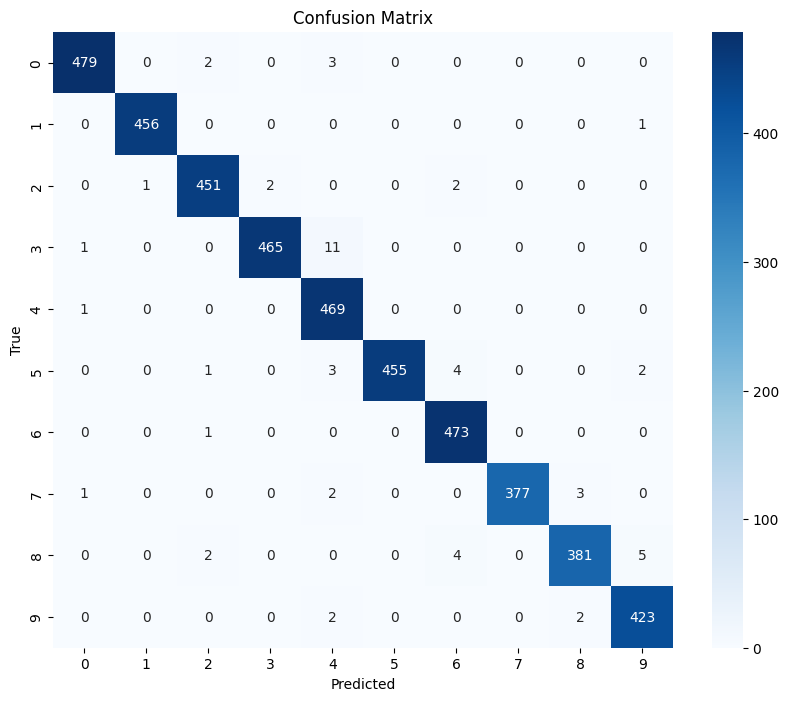

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       484
           1       1.00      1.00      1.00       457
           2       0.99      0.99      0.99       456
           3       1.00      0.97      0.99       477
           4       0.96      1.00      0.98       470
           5       1.00      0.98      0.99       465
           6       0.98      1.00      0.99       474
           7       1.00      0.98      0.99       383
           8       0.99      0.97      0.98       392
           9       0.98      0.99      0.99       427

    accuracy                           0.99      4485
   macro avg       0.99      0.99      0.99      4485
weighted avg       0.99      0.99      0.99      4485



In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Prédictions sur l'ensemble de test
test_predictions = np.argmax(model.predict(test_images), axis=1)

# Matrice de confusion
cm = confusion_matrix(np.argmax(test_labels_encoded, axis=1), test_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Rapport de classification
print(classification_report(np.argmax(test_labels_encoded, axis=1), test_predictions))


In [19]:
import cv2
import numpy as np

# Chemin de l'image à tester
test_image_path = '/kaggle/input/test100/tes.png'
# Charger l'image
test_image = cv2.imread(test_image_path)

# Vérifier si l'image a été correctement chargée
if test_image is not None:
    # Redimensionner l'image à la taille utilisée pour l'entraînement (100x100)
    test_image_resized = cv2.resize(test_image, (100, 100))
    
    # Normaliser les pixels entre 0 et 1
    test_image_normalized = test_image_resized / 255.0
    
    # Ajouter une dimension supplémentaire pour correspondre au format attendu par le modèle
    test_image_prepared = np.expand_dims(test_image_normalized, axis=0)
    
    # Faire la prédiction
    predictions = model.predict(test_image_prepared)
    
    # Trouver la classe prédite
    predicted_class = np.argmax(predictions)
    
    # Dictionnaire pour mapper les classes aux descriptions
    class_mapping = {
        0: "Conduite sécurisée",
        1: "Téléphone à la main (droite)",
        2: "Parler au téléphone (droite)",
        3: "Téléphone à la main (gauche)",
        4: "Parler au téléphone (gauche)",
        5: "Changer de station radio",
        6: "Boire une boisson",
        7: "Atteindre l'arrière",
        8: "Cheveux/Maquillage",
        9: "Parler avec un passager"
    }
    
    print(f"Classe prédite : c{predicted_class}")
    print(f"Comportement détecté : {class_mapping[predicted_class]}")
else:
    print("Erreur : l'image n'a pas pu être chargée.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Classe prédite : c4
Comportement détecté : Parler au téléphone (gauche)


In [20]:
model.save('/kaggle/working/my_model.h5')
